In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import permutations,combinations
from collections import Counter
from sqlalchemy import create_engine
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Optional, Text, Tuple, Union
import abc
import contextlib
import uuid

In [5]:
masterdf.dtypes

order_id             object
timestamp             int64
user_id              object
customer_city        object
product_category     object
product_id           object
quantity             object
price               float64
review_score          int64
dtype: object

In [6]:
### standardize item data types, especially string, float, and integer

masterdf['user_id'] = masterdf['user_id'].astype(str)
masterdf['product_id'] = masterdf['product_id'].astype(str)
masterdf['quantity'] = masterdf['quantity'].astype(float)

In [7]:
masterdf.dtypes

order_id             object
timestamp             int64
user_id              object
customer_city        object
product_category     object
product_id           object
quantity            float64
price               float64
review_score          int64
dtype: object

In [8]:
interactions_dict = masterdf.groupby(['user_id', 'product_id', 'timestamp'])[ 'quantity'].sum().reset_index()

interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

items_dict = masterdf[['product_id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

interactions = interactions.map(lambda x: {
                                            'user_id' : x['user_id'], 
                                            'product_id' : x['product_id'], 
                                            'quantity' : float(x['quantity']),
                                            "timestamp": x["timestamp"] })

items = items.map(lambda x: x['product_id'])

In [9]:
### get unique item and user id's as a lookup table
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1000).map(lambda x: x["user_id"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(len(masterdf), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(round(len(masterdf)*0.6))
test = shuffled.skip(round(len(masterdf)*0.6)).take(round(len(masterdf)*0.2))

In [10]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        
        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers, 
        ### and then convert those to user embeddings via an Embedding layer. 
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### Query model (users)    
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model
        
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model))
                    
        # define the task, which is retrieval                                      
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )
       
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.item_model(features["product_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

In [11]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
8/8 [==============================] - 42s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0136 - factorized_top_k/top_10_categorical_accuracy: 0.0225 - factorized_top_k/top_50_categorical_accuracy: 0.0653 - factorized_top_k/top_100_categorical_accuracy: 0.1009 - loss: 186584.7639 - regularization_loss: 0.0000e+00 - total_loss: 186584.7639
Epoch 2/10
8/8 [==============================] - 41s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0961 - factorized_top_k/top_5_categorical_accuracy: 0.2616 - factorized_top_k/top_10_categorical_accuracy: 0.3230 - factorized_top_k/top_50_categorical_accuracy: 0.4957 - factorized_top_k/top_100_categorical_accuracy: 0.5903 - loss: 183019.7986 - regularization_loss: 0.0000e+00 - total_loss: 183019.7986
Epoch 3/10
8/8 [==============================] - 43s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.2213 - factorized_top_k/top_5_categorical_accuracy: 0.510

{'factorized_top_k/top_1_categorical_accuracy': 0.006603329908102751,
 'factorized_top_k/top_5_categorical_accuracy': 0.025284545496106148,
 'factorized_top_k/top_10_categorical_accuracy': 0.03764462471008301,
 'factorized_top_k/top_50_categorical_accuracy': 0.09523092955350876,
 'factorized_top_k/top_100_categorical_accuracy': 0.1461198329925537,
 'loss': 38759.34375,
 'regularization_loss': 0,
 'total_loss': 38759.34375}

In [12]:
model.evaluate(cached_test, return_dict=True)

13/13 [==============================] - 12s 889ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.0253 - factorized_top_k/top_10_categorical_accuracy: 0.0376 - factorized_top_k/top_50_categorical_accuracy: 0.0952 - factorized_top_k/top_100_categorical_accuracy: 0.1461 - loss: 39895.4358 - regularization_loss: 0.0000e+00 - total_loss: 39895.4358


{'factorized_top_k/top_1_categorical_accuracy': 0.006603329908102751,
 'factorized_top_k/top_5_categorical_accuracy': 0.025284545496106148,
 'factorized_top_k/top_10_categorical_accuracy': 0.03764462471008301,
 'factorized_top_k/top_50_categorical_accuracy': 0.09523092955350876,
 'factorized_top_k/top_100_categorical_accuracy': 0.1461198329925537,
 'loss': 38759.34375,
 'regularization_loss': 0,
 'total_loss': 38759.34375}

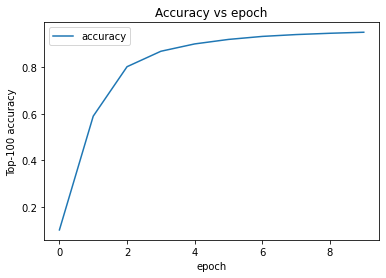

In [13]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [14]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(items.batch(100).map(model.item_model), items)

# Get recommendations.
j = str(40)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

ValueError: Attempt to convert a value (<MapDataset shapes: (None, 32), types: tf.float32>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.

In [15]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_item_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
        ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
          # Learn multiple dense layers.
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          # Make rating predictions in the final layer.
          tf.keras.layers.Dense(1)
  ])

    def call(self, inputs):

        user_id, movie_title = inputs

        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)

        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [16]:
class RetailModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            (features["user_id"], features["product_id"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["quantity"], predictions=rating_predictions)

In [17]:
model = RetailModel()

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.5))

cached_train = train.shuffle(len(masterdf)).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=100)

model.evaluate(cached_test, return_dict=True)

Epoch 1/100
8/8 [==============================] - 4s 106ms/step - root_mean_squared_error: 1.0262 - loss: 0.8871 - regularization_loss: 0.0000e+00 - total_loss: 0.8871
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - root_mean_squared_error: 0.1390 - loss: 0.0161 - regularization_loss: 0.0000e+00 - total_loss: 0.0161
Epoch 3/100
8/8 [==============================] - 0s 46ms/step - root_mean_squared_error: 0.0136 - loss: 1.9098e-04 - regularization_loss: 0.0000e+00 - total_loss: 1.9098e-04
Epoch 4/100
8/8 [==============================] - 0s 48ms/step - root_mean_squared_error: 0.0176 - loss: 3.1811e-04 - regularization_loss: 0.0000e+00 - total_loss: 3.1811e-04
Epoch 5/100
8/8 [==============================] - 0s 49ms/step - root_mean_squared_error: 0.0218 - loss: 4.8438e-04 - regularization_loss: 0.0000e+00 - total_loss: 4.8438e-04
Epoch 6/100
8/8 [==============================] - 0s 47ms/step - root_mean_squared_error: 0.0250 - loss: 6.2669e-04 - regularization_l

{'root_mean_squared_error': 0.0033059418201446533,
 'loss': 1.1109805200248957e-05,
 'regularization_loss': 0,
 'total_loss': 1.1109805200248957e-05}

In [18]:
## Basic housekeeping to prepare feature vocabularies

## timestamp is an exmaple of continuous features, which needs to be rescaled, or otherwise it will be 
## too large for the model.
## there are other methods to reduce the size of the timestamp, ,such as standardization and normalization
## here we use discretization, which puts them into buckets of categorical features, 

timestamps = np.concatenate(list(interactions.map(lambda x: x["timestamp"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,)

item_titles = interactions.batch(round(len(masterdf)*0.1)).map(lambda x: x["product_id"])
user_ids = interactions.batch(round(len(masterdf)*0.1)).map(lambda x: x["user_id"])

unique_item_titles = np.unique(np.concatenate(list(item_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [19]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(len(masterdf), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(round(len(masterdf)*0.6))
test = shuffled.skip(round(len(masterdf)*0.6)).take(round(len(masterdf)*0.6))

cached_train = train.shuffle(len(masterdf)).batch(2048)
cached_test = test.batch(4096).cache()

In [20]:
### user model

class UserModel(tf.keras.Model):

    def __init__(self, use_timestamps):
        super().__init__()

        self._use_timestamps = use_timestamps

        ## embed user id from unique_user_ids
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        ## embed timestamp
        if use_timestamps:
            self.timestamp_embedding = tf.keras.Sequential([
              tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
              tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
            ])
            self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

            self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        if not self._use_timestamps:
              return self.user_embedding(inputs["user_id"])

        ## all features here
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            self.normalized_timestamp(inputs["timestamp"]),
        ], axis=1)

In [21]:
### candidate model

class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        ## embed title from unique_item_titles
        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, 32)
        ])

        ## processing text features: item title vectorizer (see self.title_vectorizer)
        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        ## we apply title vectorizer to items
        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(items)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [22]:
class RetailModel(tfrs.models.Model):

    def __init__(self, use_timestamps):
        super().__init__()
        
        ## query model is user model
        self.query_model = tf.keras.Sequential([
          UserModel(use_timestamps),
          tf.keras.layers.Dense(32)
        ])
        
        ## candidate model is the item model
        self.candidate_model = tf.keras.Sequential([
          ItemModel(),
          tf.keras.layers.Dense(32)
        ])
        
        ## retrieval task, choose metrics
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
        })
        
        item_embeddings = self.candidate_model(features["product_id"])

        return self.task(query_embeddings, item_embeddings)

In [23]:
model = RetailModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=3)
model.evaluate(cached_test, return_dict=True)

Epoch 1/3
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
78/78 [==============================] - 25s 286ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0109 - factorized_top_k/top_5_categorical_accuracy: 0.0212 - factorized_top_k/top_10_categorical_accuracy: 0.0297 - factorized_top_k/top_50_categorical_accuracy: 0.0733 - factorized_top_k/top_100_categorical_accuracy: 0.1138 - loss: 15460.0235 - regularization_loss: 0.0000e+00 - total_loss: 15460.0235
Epoch 2/3
78/78 [==============================] - 27s 309ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0232 - factorized_top_k/top_5_categorical_accuracy: 0.0967 - factorized_top_k/top_10_categorical_accuracy: 0.1442 - factorized_top_k/top_50_categorical_accuracy: 0.3182 - factorized_top_k/top_100_categorical_accuracy: 0.4224 - loss: 13813.9302 - regularization_loss: 0.0000e+00 - total_loss: 13813.9302
Epoch 3/3
78/78 [==============================] - 25s

{'factorized_top_k/top_1_categorical_accuracy': 0.006236536893993616,
 'factorized_top_k/top_5_categorical_accuracy': 0.02241578884422779,
 'factorized_top_k/top_10_categorical_accuracy': 0.036008238792419434,
 'factorized_top_k/top_50_categorical_accuracy': 0.1006782129406929,
 'factorized_top_k/top_100_categorical_accuracy': 0.15537725389003754,
 'loss': 34742.41796875,
 'regularization_loss': 0,
 'total_loss': 34742.41796875}

In [24]:
model =  RetailModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

model.evaluate(cached_test, return_dict=True)

ValueError: in user code:

    C:\Users\joaoa\anaconda3\lib\site-packages\keras\engine\base_preprocessing_layer.py:121 adapt_step  *
        self._adapt_maybe_build(data)
    C:\Users\joaoa\anaconda3\lib\site-packages\keras\engine\base_preprocessing_layer.py:284 _adapt_maybe_build  **
        self.build(data_shape)
    C:\Users\joaoa\anaconda3\lib\site-packages\keras\layers\preprocessing\normalization.py:145 build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None], with unknown axis at index: 0


In [25]:
class Model(tfrs.models.Model):

    def __init__(self,
                 rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        embedding_dimension = 32

        # item models.
        self.item_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_item_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
        ])
            
        ## user model    
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and item embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        
        ## this is Relu-Based DNN
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # rating and retrieval task.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
            
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.item_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        
        # And pick out the item features and pass them into the item model.
        item_embeddings = self.item_model(features["product_id"])

        return (
            user_embeddings,
            item_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and item embeddings.
            self.rating_model(
                tf.concat([user_embeddings, item_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ## ratings go here as a method to compute loss
        ratings = features.pop("quantity")

        user_embeddings, item_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

In [26]:
model = Model(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
20/20 [==============================] - 28s 1s/step - root_mean_squared_error: 0.2692 - factorized_top_k/top_1_categorical_accuracy: 2.5084e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0013 - factorized_top_k/top_10_categorical_accuracy: 0.0027 - factorized_top_k/top_50_categorical_accuracy: 0.0144 - factorized_top_k/top_100_categorical_accuracy: 0.0294 - loss: 0.0672 - regularization_loss: 0.0000e+00 - total_loss: 0.0672
Epoch 2/3
20/20 [==============================] - 24s 1s/step - root_mean_squared_error: 0.0125 - factorized_top_k/top_1_categorical_accuracy: 2.3830e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0012 - factorized_top_k/top_10_categorical_accuracy: 0.0027 - factorized_top_k/top_50_categorical_accuracy: 0.0144 - factorized_top_k/top_100_categorical_accuracy: 0.0295 - loss: 1.5430e-04 - regularization_loss: 0.0000e+00 - total_loss: 1.5430e-04
Epoch 3/3
26/26 [==============================] - 13s 402ms/step - root_mean_squared_error: 0.0116 - 

In [27]:
model = Model(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
20/20 [==============================] - 28s 1s/step - root_mean_squared_error: 0.9953 - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy: 0.0165 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.0773 - factorized_top_k/top_100_categorical_accuracy: 0.1179 - loss: 69706.4712 - regularization_loss: 0.0000e+00 - total_loss: 69706.4712
Epoch 2/3
20/20 [==============================] - 26s 1s/step - root_mean_squared_error: 0.9840 - factorized_top_k/top_1_categorical_accuracy: 0.1023 - factorized_top_k/top_5_categorical_accuracy: 0.2763 - factorized_top_k/top_10_categorical_accuracy: 0.3424 - factorized_top_k/top_50_categorical_accuracy: 0.5164 - factorized_top_k/top_100_categorical_accuracy: 0.6073 - loss: 67502.4353 - regularization_loss: 0.0000e+00 - total_loss: 67502.4353
Epoch 3/3
26/26 [==============================] - 14s 530ms/step - root_mean_squared_error: 0.9530 - 

In [28]:
model = Model(rating_weight=0.5, retrieval_weight=0.5)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
20/20 [==============================] - 26s 1s/step - root_mean_squared_error: 0.2868 - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0134 - factorized_top_k/top_10_categorical_accuracy: 0.0219 - factorized_top_k/top_50_categorical_accuracy: 0.0620 - factorized_top_k/top_100_categorical_accuracy: 0.0955 - loss: 34873.6921 - regularization_loss: 0.0000e+00 - total_loss: 34873.6921
Epoch 2/3
20/20 [==============================] - 27s 1s/step - root_mean_squared_error: 0.0580 - factorized_top_k/top_1_categorical_accuracy: 0.0404 - factorized_top_k/top_5_categorical_accuracy: 0.1405 - factorized_top_k/top_10_categorical_accuracy: 0.1906 - factorized_top_k/top_50_categorical_accuracy: 0.3500 - factorized_top_k/top_100_categorical_accuracy: 0.4470 - loss: 34551.0197 - regularization_loss: 0.0000e+00 - total_loss: 34551.0197
Epoch 3/3
26/26 [==============================] - 14s 527ms/step - root_mean_squared_error: 0.0772 - 

In [29]:
### define interactions data and user data

### interactions 
### here we create a reference table of the user , item, and quantity purchased
interactions_dict = masterdf.groupby(['user_id', 
                                      'customer_city',
                                      'product_category',
                                      'product_id', 
                                      'timestamp'])['quantity'].sum().reset_index()

interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## item features
items_dict = masterdf[['product_id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items

# Select the basic features.
interactions = interactions.map(lambda x: {
    'user_id' : str(x['user_id']), 
    'customer_city' : str(x['customer_city']),
    'product_id' : str(x['product_id']), 
    'product_category' : str(x['product_category']),   
    'quantity' : int(x['quantity']),
    "timestamp": int(x["timestamp"])
})

items = items.map(lambda x: str(x['product_id']))
city = interactions.map(lambda x: str(x['customer_city']))
category = interactions.map(lambda x: str(x['product_category']))

In [30]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))
unique_city = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["customer_city"]))))
unique_product_category = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["product_category"]))))

In [31]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32
        max_tokens = 10_000

        ## user id
        self.user_embedding = tf.keras.Sequential([
                                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                                    vocabulary=unique_user_ids, mask_token=None),
                                                    tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
                                                    ])
        #timestamp
        self.timestamp_embedding = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
                                    tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
                                ])
        self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

        self.normalized_timestamp.adapt(timestamps)
        
        # city features
        self.city_embedding = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.StringLookup(
                                            vocabulary=unique_city, mask_token=None),
                                          tf.keras.layers.Embedding(len(unique_city) + 1, self.embedding_dimension)
                                        ])
        self.city_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                                                                                        max_tokens=max_tokens)
        self.city_text_embedding = tf.keras.Sequential([
                                  self.city_vectorizer,
                                  tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                ])

        self.city_vectorizer.adapt(city)    
              
        # product category  
        self.category_embedding = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                    vocabulary=unique_product_category, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_product_category) + 1, self.embedding_dimension)
                                ])
        
        self.category_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                                                                                        max_tokens=max_tokens)
        self.category_text_embedding = tf.keras.Sequential([
                                  self.category_vectorizer,
                                  tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                ])

        self.category_vectorizer.adapt(category)
        

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            self.normalized_timestamp(inputs["timestamp"]),
            self.city_embedding(inputs["customer_city"]),
            self.city_text_embedding(inputs["customer_city"]),
            self.category_embedding(inputs["product_category"]),
            self.category_text_embedding(inputs["product_category"]),
#             self.category_embedding(['product_category'])
        ], axis=1)

In [32]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()
            
#         self.dense_layers = tf.keras.Sequential([
#                                     tfrs.layers.dcn.Cross(projection_dim=projection_dim,
#                                                           kernel_initializer="glorot_uniform"),
#                                     tf.keras.layers.Dense(256, activation="relu"),
#                                     tf.keras.layers.Dense(128, activation="relu"),
#                                     tf.keras.layers.Dense(1)
#             ])

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                        kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [33]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, self.embedding_dimension)
        ])

        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(items)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [34]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = ItemModel()

         # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [35]:
class CrossDNNModel(tfrs.models.Model):

    def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float, projection_dim=None ):
        super().__init__()
        
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)
        
        ## rating and retrieval task.
        
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
                 
        self.retrieval_task : tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def compute_loss(self, features, training=False):
        
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        #ratings = features.pop("quantity")
        
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
            "customer_city": features["customer_city"],
            "product_category": features["product_category"],
        })
    
        item_embeddings = self.candidate_model(features["product_id"])       
        retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)
    
    
        return self.retrieval_task(query_embeddings, item_embeddings)

In [38]:
cached_train = train.shuffle(len(masterdf)).batch(8192).cache()
cached_test = test.batch(4096).cache()

model = CrossDNNModel([32], rating_weight=0.5, retrieval_weight=0.5, 
                      projection_dim=None)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, validation_data=cached_test,
        validation_freq=5, epochs=3)

metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Retrieval top-5 accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
print(f"Retrieval top-1 accuracy: {metrics['factorized_top_k/top_1_categorical_accuracy']:.3f}.")
# print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

ValueError: in user code:

    C:\Users\joaoa\anaconda3\lib\site-packages\keras\engine\base_preprocessing_layer.py:121 adapt_step  *
        self._adapt_maybe_build(data)
    C:\Users\joaoa\anaconda3\lib\site-packages\keras\engine\base_preprocessing_layer.py:284 _adapt_maybe_build  **
        self.build(data_shape)
    C:\Users\joaoa\anaconda3\lib\site-packages\keras\layers\preprocessing\normalization.py:145 build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None], with unknown axis at index: 0


In [39]:
nn = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
nn.index(items.batch(1024).map(model.candidate_model), identifiers=items)
for row in interactions.batch(1).take(1):
    print(f"Best recommendations: {nn(row)[1].numpy()[:, :3].tolist()}")

AttributeError: 'Model' object has no attribute 'query_model'

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## access the kernel inside cross-network in the first later of the sequential layer in querymodel
mat = model.query_model.dense_layers.get_layer(index=0)._dense.kernel
features =  ['user_id', 
            'customer_city',
            'product_id', 
            'product_category',
            'quantity', 
            'timestamp']

block_norm = np.ones([len(features), len(features)])

dim = model.query_model.embedding_model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                    j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)